In [1]:
import sys
sys.path.append("src")

In [122]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from typing import Dict, List
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from src.custom_types import DataFrame
from src.utils.utils import add_columns, parse_config
from src.utils.env import ENV
from src.utils.safe_io import load_data

%matplotlib inline


In [151]:
fig_size = (8, 5)
random_state = 112

In [74]:
parse_config()


def get_dfs() -> Dict[str, DataFrame]:
    dfs: Dict[str, DataFrame] = {}
    for data_name, eda_info in ENV.CONFIG['eda'].items():
        dfs[data_name] = load_data(data_name)
        if extra_columns := eda_info.get('extra_columns'):
            dfs[data_name] = add_columns(dfs[data_name], extra_columns)
    return dfs


def rename_agg_columns(df: DataFrame):
    new_columns = ['_'.join(col) for col in df.columns]
    df.columns = new_columns


def to_datetime_columns(df: DataFrame, columns: List[str]):
    for col in columns:
        df.loc[:, col] = pd.to_datetime(df.loc[:, col])


def drop_correlated(df: DataFrame, threshold: float) -> DataFrame:
    df_corr = df.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(
        df_corr.mask(np.tril(np.ones([len(df_corr)] * 2, dtype=bool))).abs() >
        threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df[un_corr_idx]
    return df_out

def get_ohe_columns(category_columns: List[str], ohe_category: List[np.ndarray]) -> List[str]:
    columns = []
    for i, category_column in enumerate(category_columns):
        ohe_columns = category_column + '_' + ohe_category[i].astype(str).astype(object)
        columns.extend(ohe_columns.tolist())
    return columns


In [105]:
dfs = get_dfs()

df_customer = dfs['customers']
df_order = dfs['orders']
df_payment = dfs['payments']
df_item = dfs['items']
df_item = df_item[df_item.price >= 0]
df_item.loc[:, 'freight_value'] = df_item.freight_value.clip(0)

df_region = pd.read_csv('./data/us_region.csv', sep='|')

C:\Users\wvjgsuhp\AppData\Local\Temp\ipykernel_23860\1396249671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_item.loc[:, 'freight_value'] = df_item.freight_value.clip(0)


# Feature Generation

In [6]:
df_customer.head(3)

,customer_id,customer_unique_id,customer_city,customer_state,customer_zip_code
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,New Jamesville,AK,99765
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,West Peter,VA,23267
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,New Karen,OR,97707


In [7]:
df_item.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,price_over_freight,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2020-09-19 09:45:35,56.9,12.29,4.629780,69.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2020-05-03 11:05:13,237.9,18.93,12.567353,256.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2021-01-18 14:48:30,197.0,16.87,11.677534,213.87


In [108]:
datetime_columns = [
    'order_estimated_delivery_date', 'order_delivered_customer_date',
    'order_delivered_carrier_date', 'order_approved_at',
    'order_purchase_timestamp']
to_datetime_columns(df_order, datetime_columns)
delivery_time = (df_order.order_delivered_customer_date -
                 df_order.order_purchase_timestamp) / np.timedelta64(1, 'D')
df_order = df_order.assign(delivery_time=delivery_time)


def get_is_late(columns: str) -> pd.Series:
    column = columns.pop(0)
    date_column = df_order.loc[:, column]
    is_late = (date_column - df_order.order_estimated_delivery_date).dt.days > 0
    if not columns:
        return np.where(is_late, True, np.nan)
    if column == 'order_delivered_customer_date':
        return np.where(date_column.notna(), is_late, get_is_late(columns))

    return np.where(is_late, True, get_is_late(columns))


is_late = get_is_late(datetime_columns[1:])
df_order = df_order.assign(is_late=is_late)

purchase_time = df_order.order_purchase_timestamp.dt.hour + df_order.order_purchase_timestamp.dt.minute / 60
df_order = df_order.assign(purchase_time=purchase_time)

df_order.head(3)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,is_late,purchase_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2020-10-02 10:56:33,2020-10-02 11:07:15,2020-10-04 19:55:00,2020-10-10 21:25:13,2020-10-18,8.436574,0.0,10.933333
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2021-07-24 20:41:37,2021-07-26 03:24:27,2021-07-26 14:31:00,2021-08-07 15:27:45,2021-08-13,13.782037,0.0,20.683333
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2021-08-08 08:38:49,2021-08-08 08:55:23,2021-08-08 13:50:00,2021-08-17 18:06:29,2021-09-04,9.394213,0.0,8.633333


In [109]:
item_agg = {
    'order_id': 'count',
    'price': ['sum', 'mean'],
    'total_price': ['sum', 'mean'],
    'freight_value': ['sum', 'mean']
}
df_item_agg = df_item.groupby('order_id').agg(item_agg)
rename_agg_columns(df_item_agg)
df_item_agg.rename(columns={'order_id_count': 'item_count'}, inplace=True)
df_item_agg.reset_index(inplace=True)

print(df_item_agg.shape)
df_item_agg.head(3)

(98664, 8)


,order_id,item_count,price_sum,price_mean,total_price_sum,total_price_mean,freight_value_sum,freight_value_mean
0,00010242fe8c5a6d1ba2dd792cb16214,1,56.9,56.9,69.19,69.19,12.29,12.29
1,00018f77f2f0320c557190d7a144bdd3,1,237.9,237.9,256.83,256.83,18.93,18.93
2,000229ec398224ef6ca0657da4fc703e,1,197.0,197.0,213.87,213.87,16.87,16.87


In [10]:
df_payment.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,101.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,22.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,66.71


In [110]:
payment_agg = {
    'payment_type': 'first',
    'payment_installments': 'first',
    'payment_value': 'sum',
}
df_payment_profile = df_payment.groupby('order_id') \
    .agg(payment_agg) \
    .reset_index()
df_payment_profile.head(3)


,order_id,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,2,71.19
1,00018f77f2f0320c557190d7a144bdd3,credit_card,3,256.83
2,000229ec398224ef6ca0657da4fc703e,credit_card,5,216.87


In [111]:
df_item_purchased = df_order.merge(df_item, on='order_id', how='inner') \
    .merge(df_customer, on='customer_id', how='inner')
df_item_purchased = df_item_purchased[['customer_id', 'order_item_id']]

ohe = OneHotEncoder(handle_unknown='ignore') \
    .fit(df_item_purchased[['order_item_id']])
ohe_columns = get_ohe_columns(['order_item_id'], ohe.categories_)
df_item_purchased.loc[:, ohe_columns] = ohe.transform(df_item_purchased[['order_item_id']]).toarray()
df_item_purchased = df_item_purchased.groupby('customer_id').max()
df_item_purchased.drop(columns=['order_item_id'], inplace=True)

df_item_purchased.head(3)

,order_item_id_1,order_item_id_2,order_item_id_3,order_item_id_4,order_item_id_5,order_item_id_6,order_item_id_7,order_item_id_8,order_item_id_9,order_item_id_10,...,order_item_id_12,order_item_id_13,order_item_id_14,order_item_id_15,order_item_id_16,order_item_id_17,order_item_id_18,order_item_id_19,order_item_id_20,order_item_id_21
customer_id,,,,,,,,,,,,,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000161a058600d5901f007fab4c27140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001fd6190edaaf884bcaf3d49edf079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
numerical_columns = [
    'delivery_time', 'is_late', 'payment_installments', 'item_count',
    'price_sum', 'price_mean', 'total_price_sum', 'total_price_mean',
    'freight_value_sum', 'freight_value_mean', 'purchase_time']
category_columns = ['payment_type', 'customer_state', 'region']
feature_columns = numerical_columns + category_columns
index_column = ['customer_id']

df_feature = df_customer.merge(df_order, on='customer_id', how='left') \
    .merge(df_payment_profile, on='order_id', how='left') \
    .merge(df_item_agg, on='order_id', how='left') \
    .merge(df_region, left_on='customer_state', right_on='state', how='left') \
    .loc[:, index_column + feature_columns]

ohe = OneHotEncoder(handle_unknown='ignore') \
    .fit(df_feature[category_columns])
ohe_columns = get_ohe_columns(category_columns, ohe.categories_)
df_feature.loc[:, ohe_columns] = ohe.transform(
    df_feature[category_columns]).toarray()

features = numerical_columns + ohe_columns
df_feature.set_index('customer_id', inplace=True)
df_feature = df_feature[features].merge(
    df_item_purchased, left_index=True, right_index=True, how='left')

print(df_feature.isna().sum())
df_feature.dropna(inplace=True)

variance_threshold_ = 0.95
variance_threshold = variance_threshold_ * (1 - variance_threshold_)
variance_selector = VarianceThreshold(threshold=variance_threshold)
variance_selector.fit(df_feature)
use_column_indices = variance_selector.get_support(indices=True)
df_feature = df_feature.iloc[:, use_column_indices]
df_feature = drop_correlated(df_feature, .95)

df_feature.describe()


delivery_time           2965
is_late                 2952
payment_installments       1
item_count               777
price_sum                777
                        ... 
order_item_id_17         777
order_item_id_18         777
order_item_id_19         777
order_item_id_20         777
order_item_id_21         777
Length: 94, dtype: int64


,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
count,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000
mean,12.558281,0.067729,2.913219,1.142112,135.897289,124.231123,22.218706,19.652025,15.265300,0.758948,0.198916,0.236584,0.174246,0.295305,0.079058,0.214806,0.099862
std,9.545705,0.251281,2.707010,0.536576,208.968980,189.701070,21.448768,15.692114,5.333776,0.427724,0.399187,0.424987,0.379323,0.456182,0.269831,0.410690,0.299818
min,0.533414,0.000000,0.000000,1.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.766377,0.000000,1.000000,1.000000,44.990000,40.900000,13.210000,12.790000,11.666667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.217500,0.000000,2.000000,1.000000,85.000000,77.900000,16.720000,15.940000,15.566667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.720255,0.000000,4.000000,1.000000,148.900000,138.000000,23.630000,20.730000,19.600000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,209.628611,1.000000,24.000000,20.000000,13432.000000,6733.000000,1790.960000,409.680000,23.983333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
outlier_features = ['delivery_time', 'item_count', 'price_sum', 'price_mean' ,'freight_value_sum','freight_value_mean']
standard_features = [c for c in df_feature.columns if c not in outlier_features]

df_x = df_feature.copy()
for col in outlier_features:
    df_x.loc[:, col] = RobustScaler().fit_transform(df_x.loc[:, [col]])
for col in standard_features:
    df_x.loc[:, col] = StandardScaler().fit_transform(df_x.loc[:, [col]])

df_x.describe()

,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
count,96473.000000,9.647300e+04,9.647300e+04,96473.000000,96473.000000,96473.000000,96473.000000,96473.000000,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04,9.647300e+04
mean,0.261427,-6.775982e-18,-4.625344e-17,0.142112,0.489821,0.477149,0.527707,0.467509,-1.550374e-16,-1.471567e-16,-5.126178e-17,-5.892158e-17,2.946079e-17,-1.067954e-17,2.194829e-17,7.376246e-17,6.650774e-17
std,1.066097,1.000005e+00,1.000005e+00,0.536576,2.011057,1.953667,2.058423,1.976337,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.081552,-2.695352e-01,-1.076182e+00,0.000000,-0.816091,-0.800206,-1.604607,-2.007557,-2.862021e+00,-1.774397e+00,-4.983053e-01,-5.566888e-01,-4.593625e-01,-6.473442e-01,-2.929935e-01,-5.230401e-01,-3.330780e-01
25%,-0.385433,-2.695352e-01,-7.067684e-01,0.000000,-0.385045,-0.381050,-0.336852,-0.396725,-6.746913e-01,5.635718e-01,-4.983053e-01,-5.566888e-01,-4.593625e-01,-6.473442e-01,-2.929935e-01,-5.230401e-01,-3.330780e-01
50%,0.000000,-2.695352e-01,-3.373552e-01,0.000000,0.000000,0.000000,0.000000,0.000000,5.650183e-02,5.635718e-01,-4.983053e-01,-5.566888e-01,-4.593625e-01,-6.473442e-01,-2.929935e-01,-5.230401e-01,-3.330780e-01
75%,0.614567,-2.695352e-01,4.014711e-01,0.000000,0.614955,0.618950,0.663148,0.603275,8.126930e-01,5.635718e-01,-4.983053e-01,-5.566888e-01,-4.593625e-01,1.544773e+00,-2.929935e-01,-5.230401e-01,-3.330780e-01
max,22.270923,3.710090e+00,7.789735e+00,19.000000,128.447695,68.538620,170.272553,49.589421,1.634504e+00,5.635718e-01,2.006802e+00,1.796336e+00,2.176930e+00,1.544773e+00,3.413045e+00,1.911899e+00,3.002300e+00


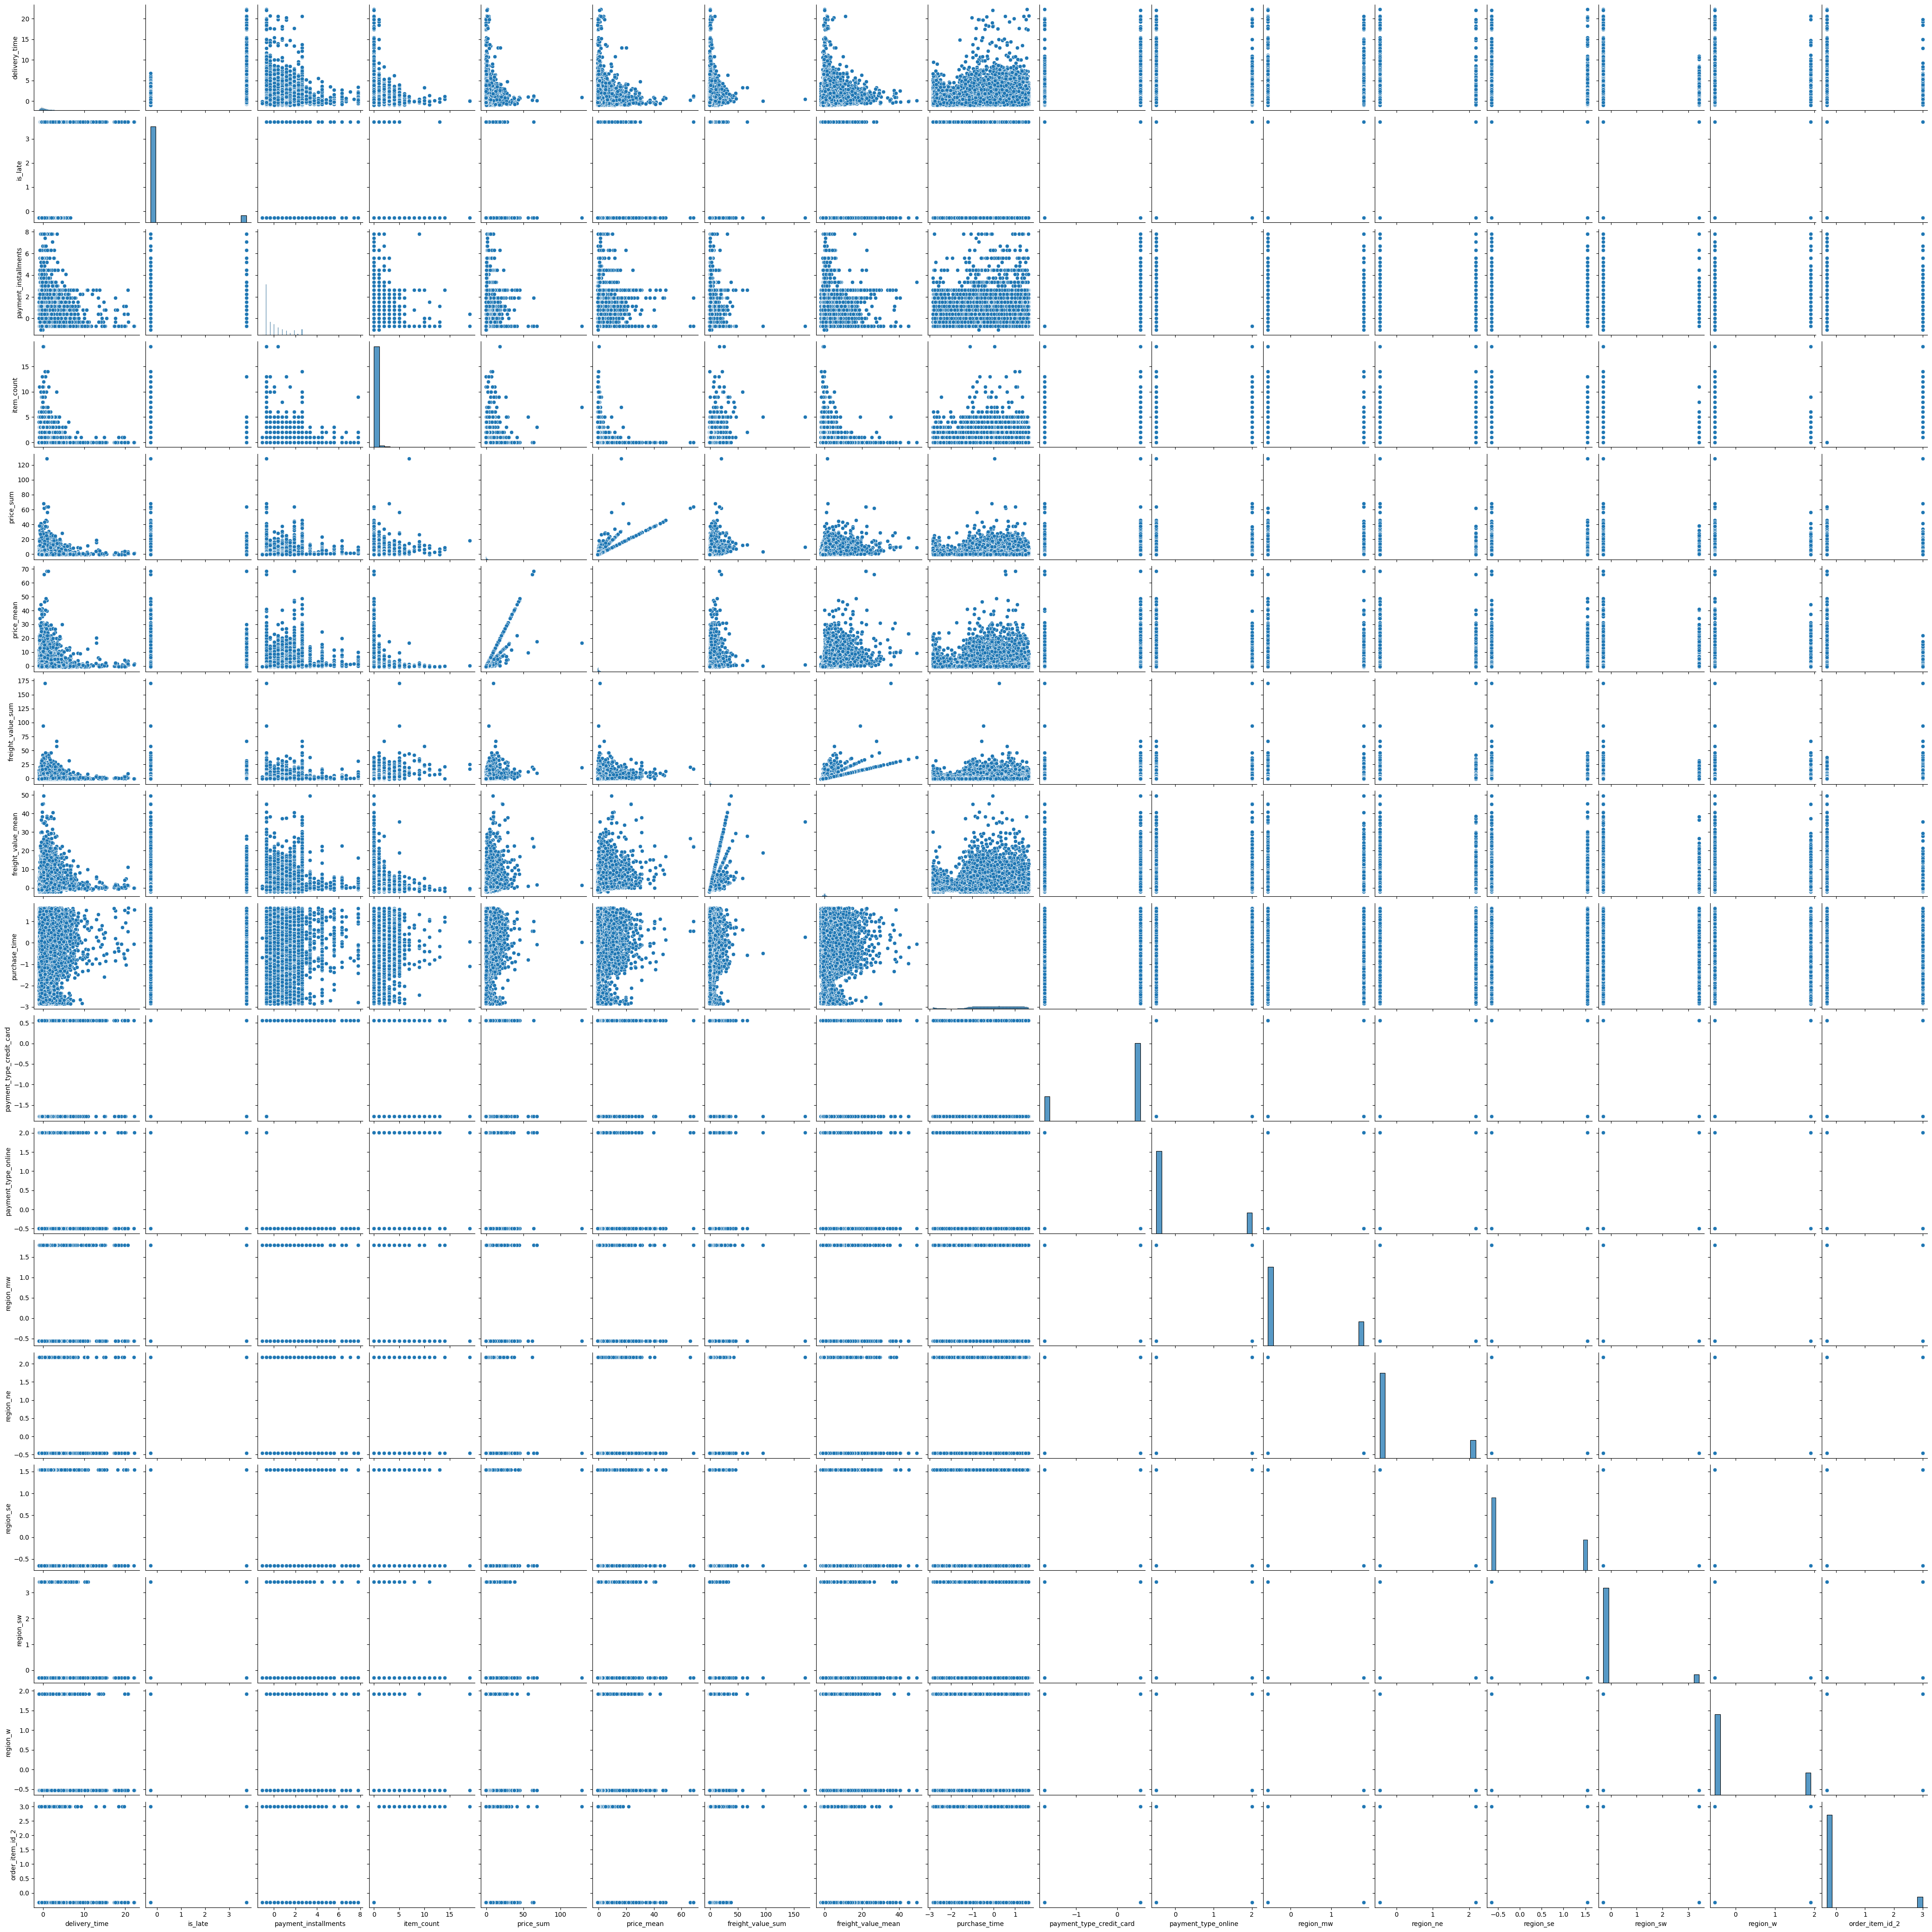

In [121]:
sns.pairplot(df_x)

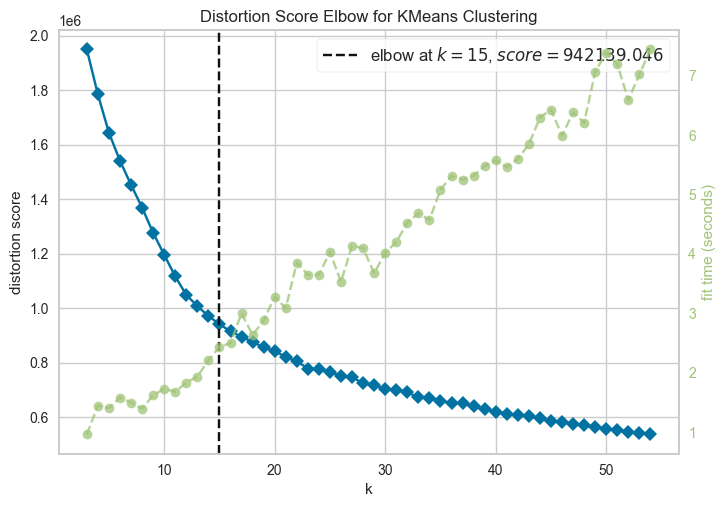

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [130]:
elb_visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=random_state), k=(3,55))
elb_visualizer.fit(df_x)
elb_visualizer.show()

k: 14


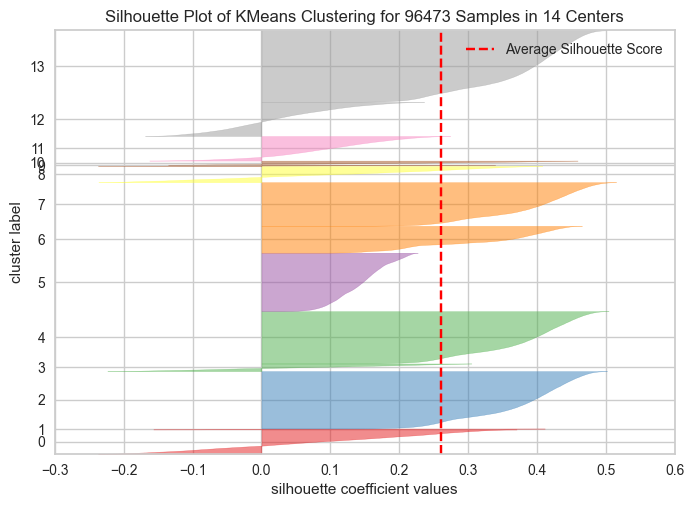

k: 15


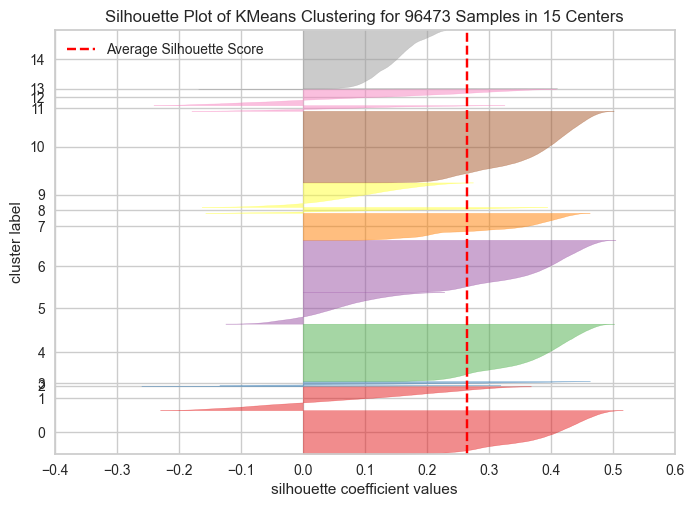

k: 16


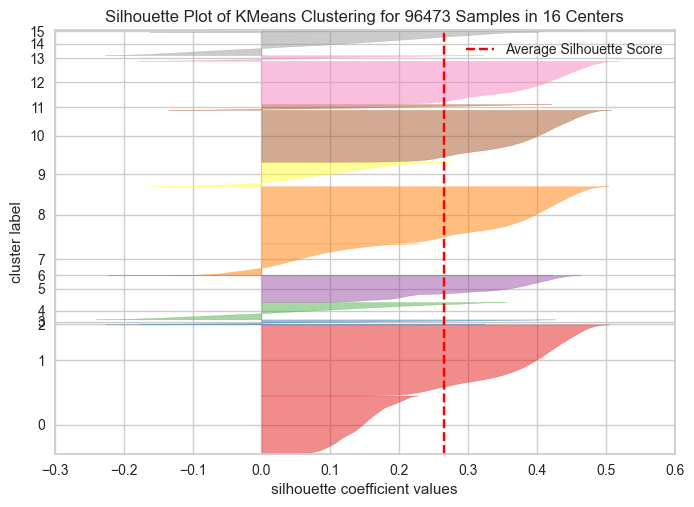

In [132]:
for k in range(14, 17):
    print('k:', k)
    km = KMeans(n_clusters=k, init='k-means++', random_state=random_state)

    sil_visualizer = SilhouetteVisualizer(km)
    sil_visualizer.fit(df_x)
    sil_visualizer.show()


k: 15


c:\Users\wvjgsuhp\projects\assessments\rentspree\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


silhouette score 0.2651602603854507


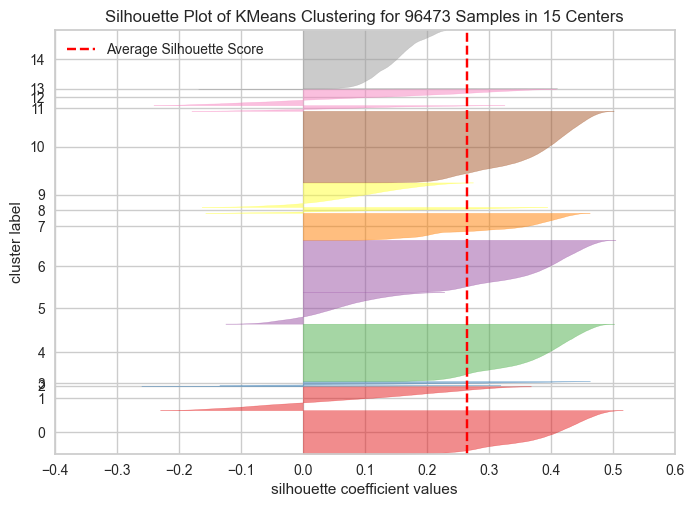

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96473 Samples in 15 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [133]:
k = 15
print('k:', k)
km = KMeans(n_clusters=k, random_state=random_state)
km.fit_transform(df_x)

sil_visualizer = SilhouetteVisualizer(km)
sil_visualizer.fit(df_x)
print('silhouette score', sil_visualizer.silhouette_score_)
sil_visualizer.show()


**Result Interpretation**

In [210]:
working_clusters = {14, 10, 7, 6, 4, 0}

df_result = df_feature.copy()
df_result.loc[:, 'cluster'] = km.labels_
df_result.dropna(subset=['cluster'], inplace=True)
df_result.loc[:, 'cluster'] = np.where(df_result.cluster.isin(working_clusters), df_result.cluster, -1).astype(str)
print(df_result.groupby('cluster').cluster.count())
df_result.head(3)

cluster
-1    25888
0      9931
10    16324
14    13199
4     13077
6     11911
7      6143
Name: cluster, dtype: int64


,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2,cluster
customer_id,,,,,,,,,,,,,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,8.812500,0.0,2.0,1.0,123.99,123.99,20.88,20.88,15.083333,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
18955e83d337fd6b2def6b18a428ac77,16.661748,0.0,8.0,1.0,288.00,288.00,46.48,46.48,20.800000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1
4e7b3e00288586ebd08712fdd0374a03,26.077153,1.0,7.0,1.0,138.94,138.94,17.79,17.79,16.116667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1


In [216]:
6143/99441

0.06177532406150381

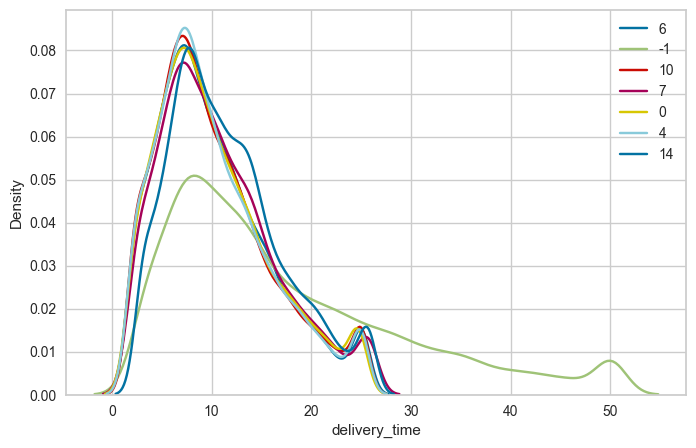

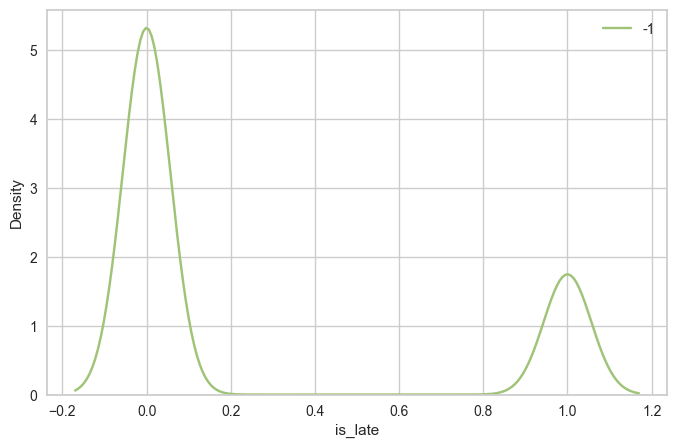

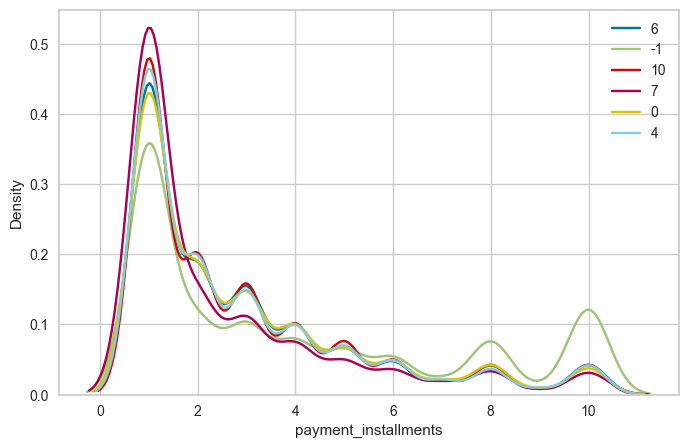

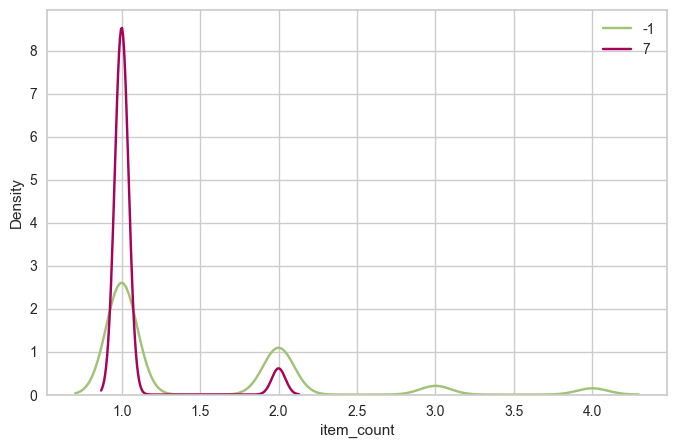

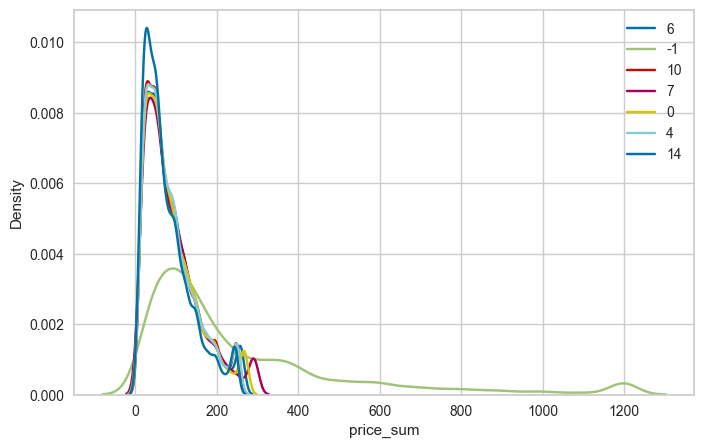

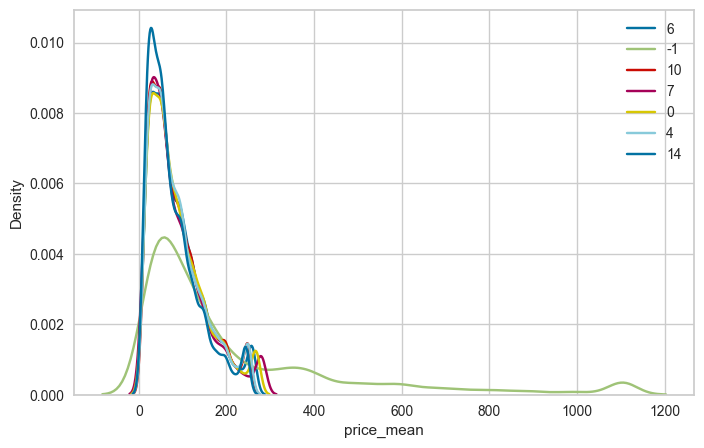

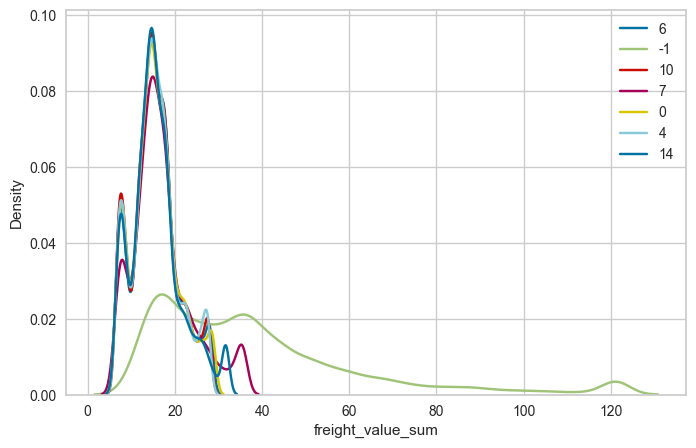

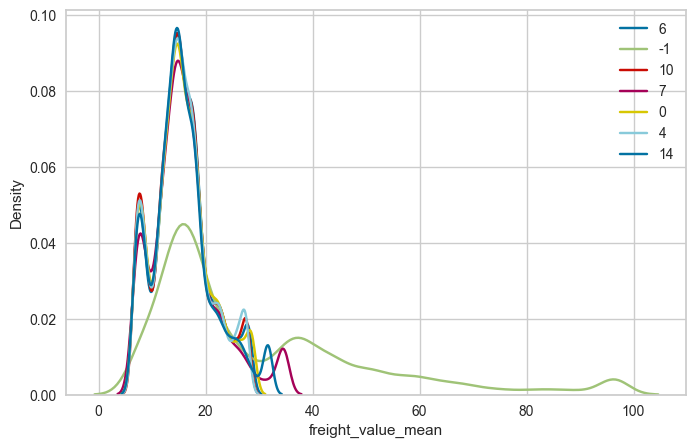

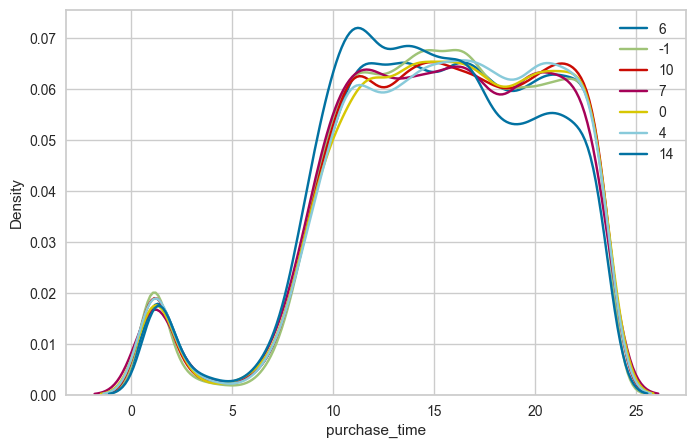

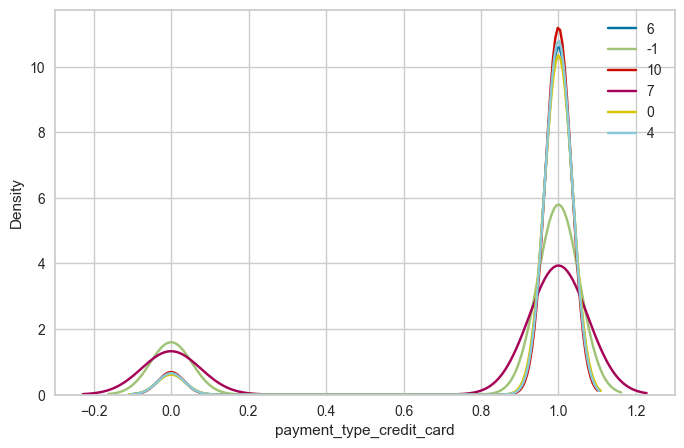

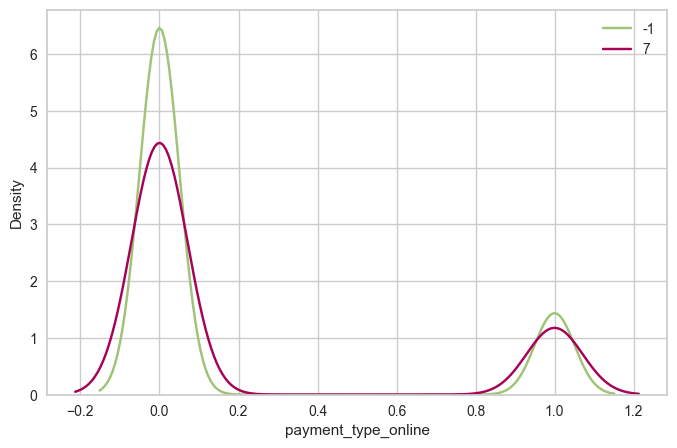

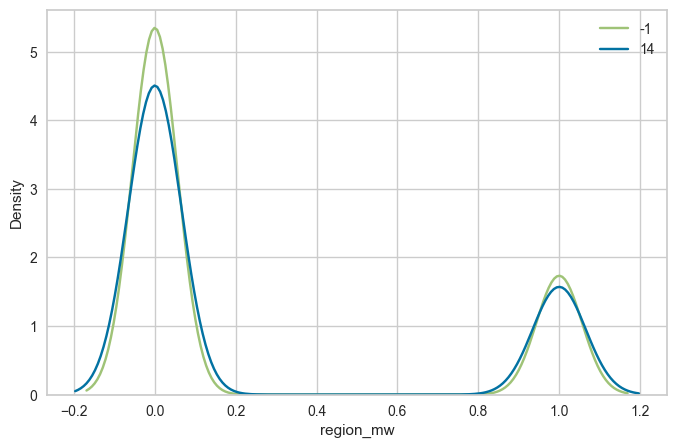

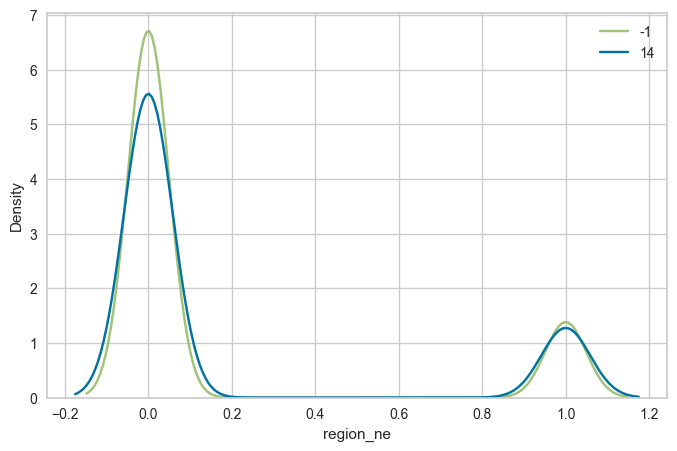

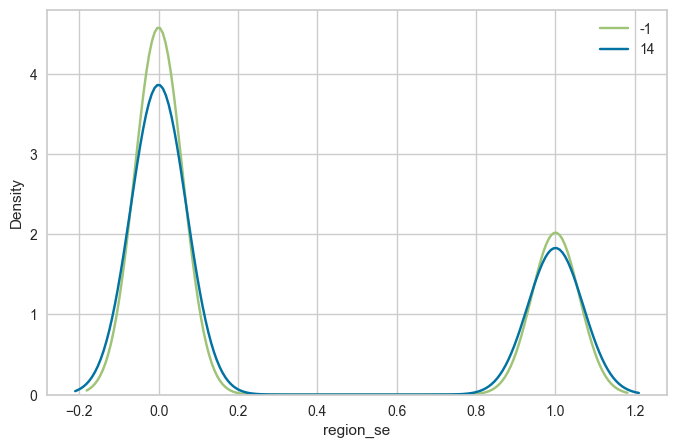

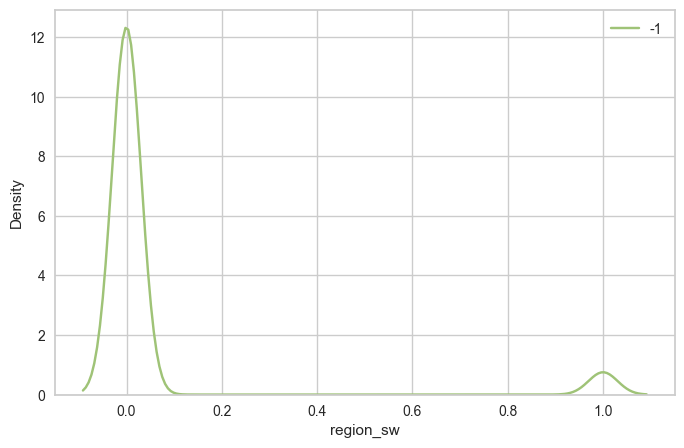

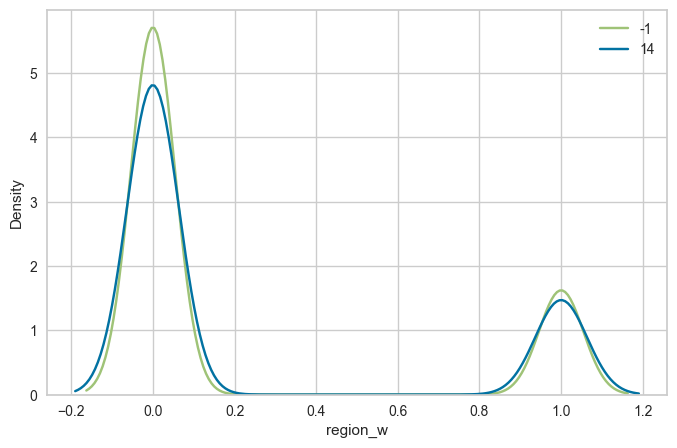

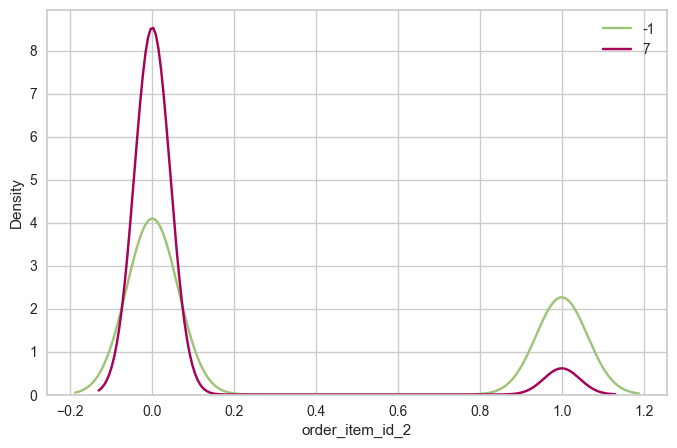

In [208]:
clusters = df_result.cluster.unique()
for col in df_result.columns[:-1]:
    plt.figure(figsize=fig_size)
    prev_n_lines = 0
    legend = []
    for cluster in clusters:
        df_result_ = df_result[df_result.cluster == cluster].copy() \
            .loc[:, [col]]
        min_max = (df_result_.loc[:, col].quantile(.025),
                   df_result_.loc[:, col].quantile(.975))
        df_result_.loc[:, col] = df_result_.loc[:, col].clip(*min_max)

        ax = sns.kdeplot(data=df_result_.squeeze(), warn_singular=False)
        if len(ax.lines) != prev_n_lines:
            prev_n_lines += 1
            legend.append(cluster)
    plt.legend(legend)
    plt.show()


In [201]:
df_result.groupby('cluster').mean().reset_index()

,cluster,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
0,-1,17.847687,0.246948,3.973888,1.512902,271.475194,228.919357,40.000131,30.636842,15.312559,0.783993,0.181706,0.244747,0.170658,0.306126,0.057324,0.221145,0.355918
1,0,10.395743,0.001611,2.936361,1.000403,88.832188,88.804739,15.625355,15.625355,15.388940,0.944316,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000403
2,10,10.352243,0.000245,2.902352,1.000000,86.421840,86.421840,15.430456,15.430456,15.359336,0.942171,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,14,11.602436,0.003409,1.000000,1.000303,78.726707,78.703621,15.771429,15.771429,14.811276,0.000000,1.000000,0.258429,0.186454,0.321236,0.000000,0.233881,0.000303
4,4,10.275529,0.000918,2.883842,1.000000,86.742654,86.742654,15.503128,15.503128,15.379876,0.942953,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,10.375188,0.000672,2.938040,1.000168,88.403875,88.393649,15.583641,15.583641,15.343047,0.943246,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000168
6,7,10.771854,0.009116,2.559987,1.068696,91.665437,87.907429,16.995185,16.145669,15.197252,0.748494,0.209507,0.000000,0.000000,0.000000,1.000000,0.000000,0.066743


In [202]:
df_result.groupby('cluster').median().reset_index()

,cluster,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
0,-1,13.903791,0.0,3.0,1.0,156.80,117.875,33.58,20.85,15.616667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,9.139479,0.0,2.0,1.0,69.90,69.900,15.11,15.11,15.733333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10,9.057876,0.0,2.0,1.0,68.99,68.990,15.10,15.10,15.683333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,14,10.494421,0.0,1.0,1.0,59.00,59.000,15.10,15.10,14.850000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9.007188,0.0,2.0,1.0,68.99,68.990,15.11,15.11,15.816667,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6,9.148391,0.0,2.0,1.0,69.90,69.900,15.11,15.11,15.666667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,7,9.653391,0.0,1.0,1.0,69.90,67.900,15.71,15.22,15.533333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [212]:
df_result[~df_result.cluster.isin(('7', '-1'))].describe()

,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
count,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.000000,64442.0,64442.000000,64442.000000
mean,10.603685,0.001319,2.520794,1.000155,85.648624,85.637775,15.573390,15.573390,15.252802,0.749884,0.204820,0.255858,0.192297,0.319109,0.0,0.232736,0.000155
std,6.036373,0.036295,2.305424,0.012456,63.205477,63.200711,5.558606,5.558606,5.346134,0.433083,0.403573,0.436346,0.394108,0.466135,0.0,0.422579,0.012456
min,0.533414,0.000000,0.000000,1.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,6.210165,0.000000,1.000000,1.000000,37.990000,37.990000,12.110000,12.110000,11.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,9.309039,0.000000,1.000000,1.000000,68.000000,68.000000,15.110000,15.110000,15.550000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,13.919656,0.000000,3.000000,1.000000,117.990000,117.990000,18.230000,18.230000,19.616667,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000
max,51.497106,1.000000,23.000000,2.000000,369.900000,369.900000,38.400000,38.400000,23.983333,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [211]:
df_result[df_result.cluster == '7'].describe()

,delivery_time,is_late,payment_installments,item_count,price_sum,price_mean,freight_value_sum,freight_value_mean,purchase_time,payment_type_credit_card,payment_type_online,region_mw,region_ne,region_se,region_sw,region_w,order_item_id_2
count,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.000000,6143.0,6143.0,6143.0,6143.0,6143.0,6143.000000
mean,10.771854,0.009116,2.559987,1.068696,91.665437,87.907429,16.995185,16.145669,15.197252,0.748494,0.209507,0.0,0.0,0.0,1.0,0.0,0.066743
std,6.131101,0.095050,2.339670,0.261191,70.648856,68.989854,6.967145,6.456366,5.391772,0.433914,0.406990,0.0,0.0,0.0,0.0,0.0,0.249596
min,0.855313,0.000000,1.000000,1.000000,1.900000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000
25%,6.253715,0.000000,1.000000,1.000000,39.000000,37.500000,12.790000,12.225000,11.566667,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000
50%,9.653391,0.000000,1.000000,1.000000,69.900000,67.900000,15.710000,15.220000,15.533333,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000
75%,14.094485,0.000000,3.000000,1.000000,122.900000,118.900000,19.570000,18.415000,19.600000,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000
max,51.248553,1.000000,15.000000,4.000000,439.800000,413.990000,43.160000,43.160000,23.983333,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,1.000000


# Archive

In [116]:
nn = NearestNeighbors(n_neighbors=13)
neighbors = nn.fit(df_x)
distances, indices = neighbors.kneighbors(df_x)

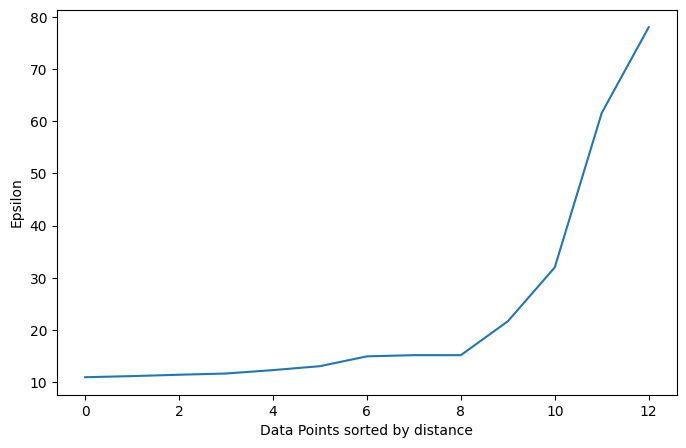

In [117]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
plt.figure(figsize=fig_size)
plt.plot(distances[-13:, 1])
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [26]:
# Compute DBSCAN
db = DBSCAN(eps=13, min_samples=8).fit(df_x)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters:', n_clusters_)
print('Estimated number of noise points:', n_noise_)
print("silhouette score: {:.3f}".format(silhouette_score(df_x, labels)))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_x[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_x[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

MemoryError: 

In [ ]:
# optics_silhouette_score = json.load(open('./silhouette.json', 'r'))
optics_silhouette_score = []

for min_samples in range(5, 23):
    # Compute OPTICS
    optics = OPTICS(min_samples=min_samples).fit(df_x)
    # db = OPTICS(eps=13, min_samples=8).fit(df_x)
    labels = optics.labels_

    # Number of clusters in labels, ignoring noise if present.
    clusters = set(labels)
    n_clusters_ = len(clusters) - (-1 in clusters)
    n_noise_ = (labels == -1).sum()

    print('Estimated number of clusters:', n_clusters_)
    print('Estimated number of noise points:', n_noise_)
    silhouette = silhouette_score(df_x, labels)
    print("silhouette score: {:.3f}".format(silhouette))

    optics_silhouette_score.append(
        {'min_samples': min_samples, 'n_clusters': n_clusters_,
         'n_noise': n_noise_, 'silhouette': silhouette})


In [119]:
optics_silhouette_score

[{'min_samples': 5,
  'n_clusters': 2142,
  'n_noise': 80637,
  'silhouette': -0.6214628542158538},
 {'min_samples': 6,
  'n_clusters': 1212,
  'n_noise': 85595,
  'silhouette': -0.6642867961179338}]